<a href="https://colab.research.google.com/github/DulanMahesh/ComputerVision/blob/main/Module_10_01_Median_and_Bilateral_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="font-size:30px;">Noise reduction with Median & Bilateral Filters</h1>

There are many situations where you might want to remove "noise" from an image. This high frequency variance of pixel intensities can come from many places, such as low light in photography, or too few render (light ray) samples in a raytraced CG image. There are many different techniques to remove noise, and in recent years more novel approaches have emerged with machine learning-based de-noising. In this notebook, however, we will focus on two classic noise reduction algorithms: Median Filters, and Bilateral Filters.

In [ ]:
# Import Libraries.
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

if 'google.colab' in str(get_ipython()):
    print("Downloading Code to Colab Environment")
    !wget https://www.dropbox.com/sh/btghqk0xvgeypl1/AAD9K7FQ_s0j3Dw-4K-JPjdya?dl=1 -O module-code.zip -q --show-progress
    !unzip -qq module-code.zip
else:
    pass

## 1. Median Filter

Median blur filtering is a nonlinear filtering technique that is most commonly used to remove **salt-and-pepper** noise from images. As the name suggests, salt-and-pepper noise shows up as randomly occurring white and black pixels that are sharply different from the surrounding. In color images, salt-and-pepper noise may appear as small random color spots.

Following patch has a salt-and-pepper noise, which is evident from the fact that the central pixel has a value way higher than the neighboring pixels.

$$
\begin{bmatrix}
30 & 32 & 29\\
31 & 255 & 35\\
35 & 30 & 33
\end{bmatrix}
$$

The median filter takes in only the pixel values in the neighborhood of the central pixel, sorts the list of values, and then replaces the value of the central pixel with the median value of the sorted list. In this case, the sorted list becomes

$$[29, 30, 30, 31, 32, 33, 35, 35, 255]$$

Thus, the median value is 32, and we replace the central pixel with 32. That's how the noise is removed.
$$
\begin{bmatrix}
30 & 32 & 29\\
31 & 32 & 35\\
35 & 30 & 33
\end{bmatrix}
$$

This is repeated for each pixel of the image.

## 2. Median Blur in OpenCV

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font style = "color:rgb(8,133,37)">Function Syntax</font>

```python
dst = cv2.medianBlur(src, ksize[, dst] )
```
`dst`: destination array of the same size and type as src.

This function has **2 required arguments:**
1. `src`:	input 1-, 3-, or 4-channel image; when ksize is 3 or 5, the image depth should be CV_8U, CV_16U, or CV_32F, for larger aperture sizes, it can only be CV_8U.

2. `ksize`:	aperture linear size; it must be an odd number and greater than 1, for example: 3, 5, 7, ...

### <font style = "color:rgb(8,133,37)">OpenCV Documentation</font>

[**`medianBlur()`**](https://docs.opencv.org/4.5.2/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9)

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

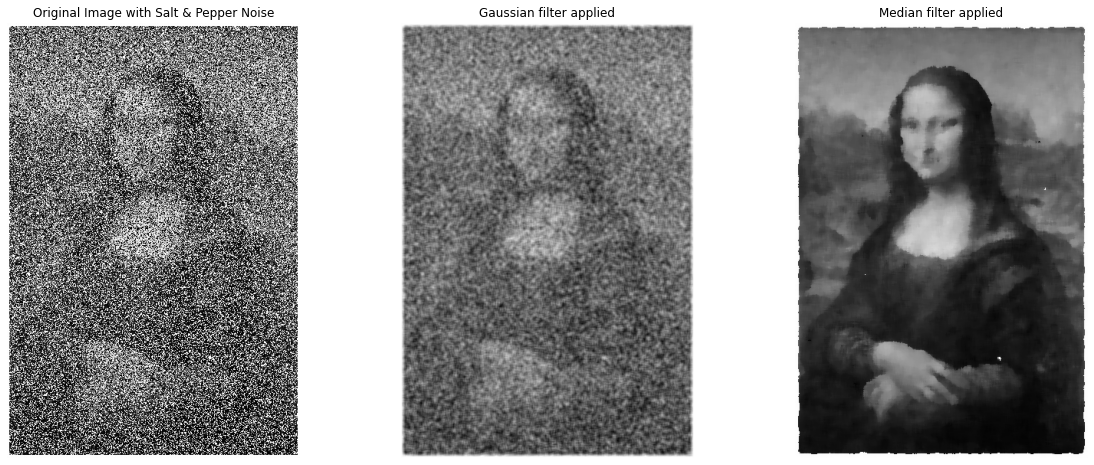

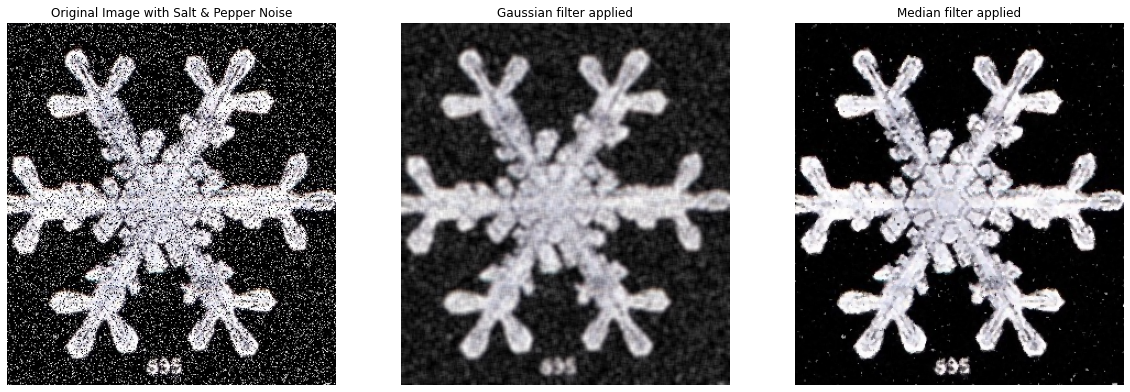

In [ ]:
# Load an images with Salt and pepper noise.
img1 = cv2.imread('images/mona_lisa.jpg')
img2 = cv2.imread('images/ice-flakes-microscopy-salt-and-pepper-noise.jpg')

# Apply median filter.
img1_median = cv2.medianBlur(img1, 9)
img2_median = cv2.medianBlur(img2, 3)

# Apply Gaussian filter for comparison.
img1_gaussian = cv2.GaussianBlur(img1, (5, 5), cv2.BORDER_DEFAULT)
img2_gaussian = cv2.GaussianBlur(img2, (5, 5), cv2.BORDER_DEFAULT)

plt.figure(figsize = (20, 8))
plt.subplot(131); plt.axis('off'); plt.imshow(img1[:,:,::-1]);          plt.title('Original Image with Salt & Pepper Noise')
plt.subplot(132); plt.axis('off'); plt.imshow(img1_gaussian[:,:,::-1]); plt.title('Gaussian filter applied')
plt.subplot(133); plt.axis('off'); plt.imshow(img1_median[:,:,::-1]);   plt.title('Median filter applied')
plt.figure(figsize = (20, 10))
plt.subplot(131); plt.axis('off'); plt.imshow(img2[:,:,::-1]);          plt.title('Original Image with Salt & Pepper Noise')
plt.subplot(132); plt.axis('off'); plt.imshow(img2_gaussian[:,:,::-1]); plt.title('Gaussian filter applied')
plt.subplot(133); plt.axis('off'); plt.imshow(img2_median[:,:,::-1]);   plt.title('Median filter applied')

# 3. Bilateral Filtering

A **Bilateral Filter** is nonlinear, edge-preserving and noise-reducing smoothing filter. Most smoothing filters (e.g. a Gaussian or a Box filter) have a parameter called $\sigma_s$ (the s in the subscript stands for "spatial") that determines the amount of smoothing. Often this value is closely related to the kernel size. A typical smoothing filter replaces the intensity value of a pixel by the weighted sum of its neighbors. The bigger the neighborhood, the smoother the filtered image looks. The size of the neighborhood is directly proportional to the parameter $\sigma_s$.

In edge-preserving filters, there are two competing objectives:

1. Smooth the image.

2. Don’t smooth the edges / color boundaries.

In other words, if we want to preserve edges, we cannot simply replace the color of a pixel by the weighted sum of its neighbors.

Consider this 3x3 image patch, shown below.

$$
\begin{bmatrix}
30 & 200 & 239\\
31 & 220 & 235\\
35 & 210 & 233
\end{bmatrix}
$$

You can see the values in the left column are much lower than the values in the center and the right columns. In other words, this patch is part of a vertical edge. In a typical filtering operation, we replace the center pixel by some weighted combination of all 9 pixels in this 3x3 neighborhood. However, in this case, a better idea is to filter the center pixel based on only the center and right-hand side columns so that the edge is retained and not blurred-out.

In bilateral filtering, while calculating the contribution of any pixel to the final output, we weigh the pixels that are close in terms of intensity to the center pixel higher as compared to the pixels whose intensities are very different from the center pixels. We want to find a weight that depends on the square of the intensity difference  ($I_p$ − $I_q$)$^2$  between the center pixel q and its neighbor p. But if you are a control freak, like most AI scientists, you will want more control over your definition of intensity difference. We can redefine intensity difference as the Gaussian function $$G_{\sigma_{r}} ( I_{p} − I_{q} )$$  and control the meaning of intensity differences using the parameter $\sigma_r$.

Additionally, just like Gaussian filtering, we also want to weight the pixels that are closer to the center pixel higher than the pixels that are farther away. So, the weights should depend on $|| p − q ||$. But again, you are likely a control freak and want to control the definition of distance. How do you do that? Well, you use a Gaussian $G_{\sigma_{s}} (|| p − q ||)$ and control the meaning of distance using the parameter $\sigma_s$.

Combining the two, a bilateral filter will output the following at center pixel q.

$$
O_{q} = \frac{1}{W_{p}}\sum_p I_p G_{\sigma_{s}} (|| p − q ||) G_{\sigma_{r}} ( I_{p} − I_{q} )
$$

Where,

$W_p$ = The normalization constant

$G_{\sigma_{s}}$= Spatial Gaussian kernel

$G_{\sigma_{r}}$ = Color / Range Gaussian kernel

q = Center pixel

p = Neighboring pixel

$I_p$  = Intensity at pixel p

$I_q$ = Intensity at pixel q



If the neighborhood pixels are edges, the difference in intensity $(I_p - I_q)$ will be higher. Since the Gaussian is a decreasing function, $G_{\sigma_{r}}(I_p - I_q)$ will have lower weights for higher values. Hence, the smoothing effect will be lower for such pixels, preserving the edges. As shown below. [Reference](http://people.csail.mit.edu/sparis/bf_course/course_notes.pdf).

<br>
<center>
<img src="https://opencv.org/wp-content/uploads/2021/09/c0-m10-Bilateral-filter-weights-of-central-pixel.png" alt="c0-m10-Bilateral-filter-weights-of-central-pixel.png">
</center>
<br>
To conclude, for bilateral filtering, we have two parameters : $\sigma_s$ and $\sigma_r$. Just like other smoothing filters $\sigma_s$ controls amount of spatial smoothing, and $\sigma_r$ (for sigma_range) controls how dissimilar colors within the neighborhood will be averaged. A higher $\sigma_r$ results in larger regions of constant color.

# 4. Bilateral Filter in OpenCV

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font style = "color:rgb(8,133,37)">Function Syntax</font>

```python
dst = cv2.bilateralFilter(src, d, sigmaColor, sigmaSpace[, dst[, borderType]])
```

**Parameters**

- **`src`**:	Source 8-bit or floating-point, 1-channel or 3-channel image.
- **`dst`**:	Destination image of the same size and type as src .
- **`d`**:	Diameter of each pixel neighborhood that is used during filtering. If it is non-positive, it is computed from sigmaSpace.
- **`sigmaColor`**:	Filter sigma in the color space. A larger value of the parameter means that farther colors within the pixel neighborhood (see sigmaSpace) will be mixed together, resulting in larger areas of semi-equal color.
- **`sigmaSpace`**:	Filter sigma in the coordinate space. A larger value of the parameter means that farther pixels will influence each other as long as their colors are close enough (see sigmaColor ). When d>0, it specifies the neighborhood size regardless of sigmaSpace. Otherwise, d is proportional to sigmaSpace.
- **`borderType`**:	border mode used to extrapolate pixels outside of the image, see BorderTypes

<hr style="border:none; height: 4px; background-color:#D3D3D3" />

### <font style="color:rgb(50,120,229)">Here, we are going to apply it on an image that has Gaussian noise. </font>
Gaussian noise can be caused by poor illumination, high temperature, noise in electronic circuit etc. Let's see the application of Bilateral filter on an image with Gaussian noise. The following images have artificially added noise: 20% and 40% noise for first and second images respectively. Feel free to play with the values of radius, sigma color and sigma space.

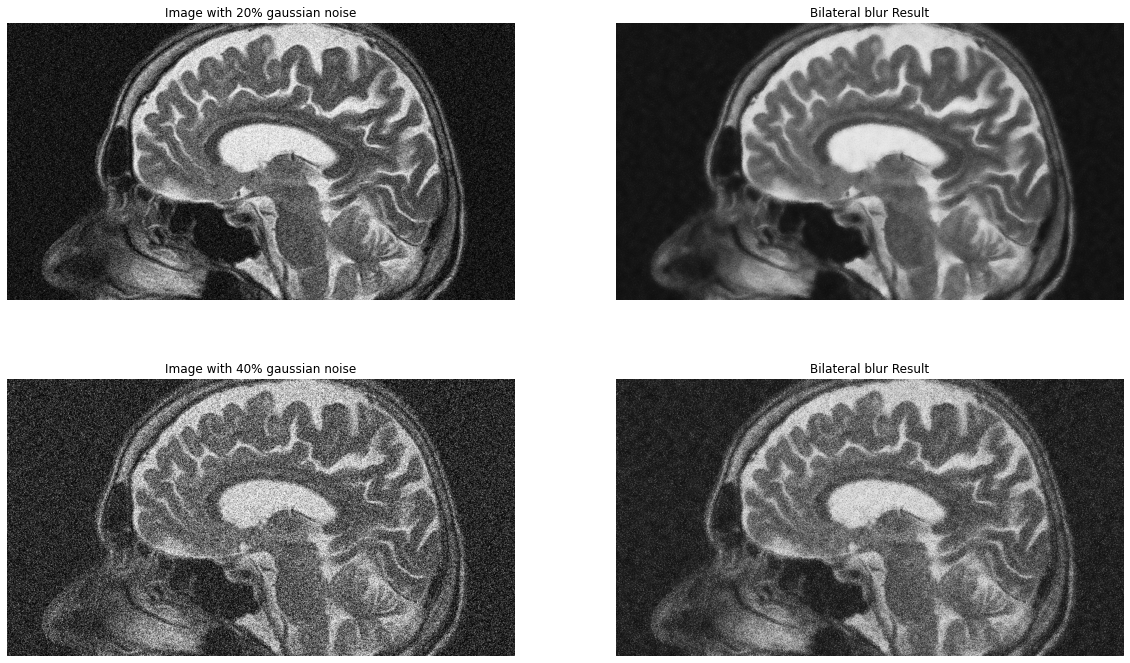

In [ ]:
# Load image with gaussian noise.
image1 = cv2.imread('images/mri-skull-20-percent-gaussian-noise.jpg')
image2 = cv2.imread('images/mri-skull-40-percent-gaussian-noise.jpg')


# diameter of the pixel neighborhood used during filtering.
dia = 20

# Larger the value the distant colours will be mixed together
# to produce areas of semi equal colors.
sigmaColor = 200

# Larger the value more the influence of the farther placed pixels
# as long as their colors are close enough.
sigmaSpace = 100

# Apply bilateralFilter.
dst1 = cv2.bilateralFilter(image1, dia, sigmaColor, sigmaSpace)
dst2 = cv2.bilateralFilter(image2, dia, sigmaColor, sigmaSpace)

plt.figure(figsize = (20, 12))
plt.subplot(221); plt.axis('off'); plt.imshow(image1[:,:,::-1]); plt.title("Image with 20% gaussian noise")
plt.subplot(222); plt.axis('off'); plt.imshow(dst1[:,:,::-1]);   plt.title("Bilateral blur Result")
plt.subplot(223); plt.axis('off'); plt.imshow(image2[:,:,::-1]); plt.title("Image with 40% gaussian noise")
plt.subplot(224); plt.axis('off'); plt.imshow(dst2[:,:,::-1]);   plt.title("Bilateral blur Result")


### <font style="color:rgb(50,120,229)">Skin smoothing filters</font>
Skin smoothing filters of Instagram, Facebook and even inbuilt camera app these days, can also be created using OpenCV bilateral filter. The following examples show the implementation.

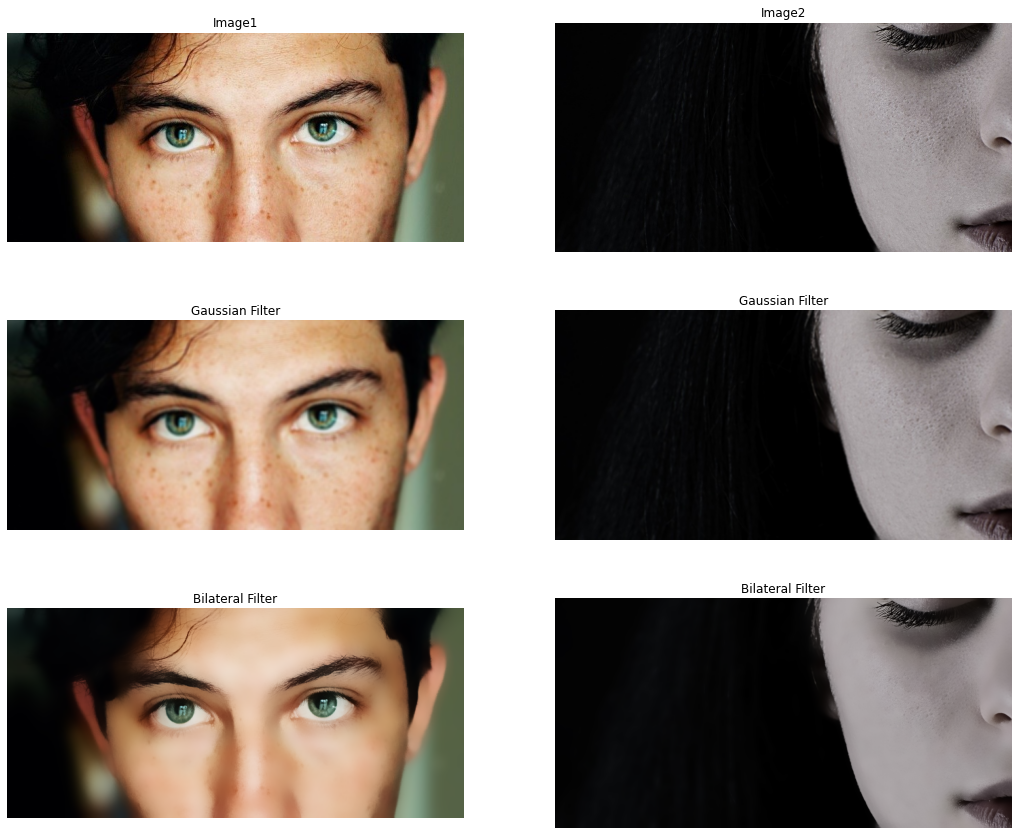

In [ ]:
# Load images.
img1 = cv2.imread('images/face-original.jpg')
img2 = cv2.imread('images/girl-skin.jpg')

# Apply Gaussian filter for comparison.
img1_gaussian = cv2.GaussianBlur(img1, (5,5), cv2.BORDER_DEFAULT)
img2_gaussian = cv2.GaussianBlur(img2, (5,5), cv2.BORDER_DEFAULT)

# Apply bilateralFilter.
img1_bilateral = cv2.bilateralFilter(img1, d = 25, sigmaColor = 90, sigmaSpace = 40)
img2_bilateral = cv2.bilateralFilter(img2, d = 30, sigmaColor = 65, sigmaSpace = 15)

# Display.
plt.figure(figsize = (18, 15))
plt.subplot(321); plt.axis('off'); plt.imshow(img1[:,:,::-1]);           plt.title('Image1')
plt.subplot(322); plt.axis('off'); plt.imshow(img2[:,:,::-1]);           plt.title('Image2')
plt.subplot(323); plt.axis('off'); plt.imshow(img1_gaussian[:,:,::-1]);  plt.title('Gaussian Filter')
plt.subplot(324); plt.axis('off'); plt.imshow(img2_gaussian[:,:,::-1]);  plt.title('Gaussian Filter')
plt.subplot(325); plt.axis('off'); plt.imshow(img1_bilateral[:,:,::-1]); plt.title('Bilateral Filter')
plt.subplot(326); plt.axis('off'); plt.imshow(img2_bilateral[:,:,::-1]); plt.title('Bilateral Filter')

### Conclusion
* Median filtering works best on images with salt and pepper type noise.
* Bilateral filtering helps smooth noise while maintaining sharp edges.